In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### **Traitement de la base de donnée**

In [3]:
# Load the dataset
df = pd.read_csv('dataset/telco_dataset.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
def audit(df):
    return pd.DataFrame({
        "dtype": df.dtypes,
        "missing": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique": df.nunique(),
        "sample": df.iloc[0]
    })
audit(df)

,dtype,missing,missing_%,unique,sample
customerID,object,0,0.0,7043,7590-VHVEG
gender,object,0,0.0,2,Female
SeniorCitizen,int64,0,0.0,2,0
Partner,object,0,0.0,2,Yes
Dependents,object,0,0.0,2,No
tenure,int64,0,0.0,73,1
PhoneService,object,0,0.0,2,No
MultipleLines,object,0,0.0,3,No phone service
InternetService,object,0,0.0,3,DSL
OnlineSecurity,object,0,0.0,3,No


In [5]:
#on transforme les variables yes / no en binaire 
binary_cols = ["gender",'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
mapping = {'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0}
for col in binary_cols:
    df[col] = df[col].str.capitalize().map(mapping)    
df[binary_cols].head()

,gender,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,1,1,0,0,1,0
1,0,0,0,1,0,0
2,0,0,0,1,1,1
3,0,0,0,0,0,0
4,1,0,0,1,1,1


In [6]:
#on crée des dummy pour les variable quali avec plus de deux output 
dummy_cols = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport","StreamingTV" ,"StreamingMovies", "Contract", "PaymentMethod"]
df = pd.get_dummies(df, columns= dummy_cols,dtype=int)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,0,1,0,1,0,1,29.85,29.85,...,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,0,0,0,0,34,1,0,56.95,1889.5,...,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,0,0,0,2,1,1,53.85,108.15,...,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,0,0,0,0,45,0,0,42.30,1840.75,...,1,0,0,0,1,0,1,0,0,0
4,9237-HQITU,1,0,0,0,2,1,1,70.70,151.65,...,1,0,0,1,0,0,0,0,1,0


In [7]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,Churn,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.495244,0.162147,0.483033,0.299588,32.371149,0.903166,0.592219,64.761692,0.265370,0.481329,...,0.395428,0.216669,0.387903,0.550192,0.209144,0.240664,0.219225,0.216101,0.335794,0.228880
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.491457,30.090047,0.441561,0.499687,...,0.488977,0.412004,0.487307,0.497510,0.406726,0.427517,0.413751,0.411613,0.472301,0.420141
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,89.850000,1.000000,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
audit(df)

,dtype,missing,missing_%,unique,sample
customerID,object,0,0.0,7043,7590-VHVEG
gender,int64,0,0.0,2,1
SeniorCitizen,int64,0,0.0,2,0
Partner,int64,0,0.0,2,1
Dependents,int64,0,0.0,2,0
tenure,int64,0,0.0,73,1
PhoneService,int64,0,0.0,2,0
PaperlessBilling,int64,0,0.0,2,1
MonthlyCharges,float64,0,0.0,1585,29.85
TotalCharges,object,0,0.0,6531,29.85


on remarque que totalcharge est de type objext, certain champs sont vide 

In [9]:
# Conversion en numérique, les espaces deviennent des NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [10]:
df.isna().sum()

customerID                                  0
gender                                      0
SeniorCitizen                               0
Partner                                     0
Dependents                                  0
tenure                                      0
PhoneService                                0
PaperlessBilling                            0
MonthlyCharges                              0
TotalCharges                               11
Churn                                       0
MultipleLines_No                            0
MultipleLines_No phone service              0
MultipleLines_Yes                           0
InternetService_DSL                         0
InternetService_Fiber optic                 0
InternetService_No                          0
OnlineSecurity_No                           0
OnlineSecurity_No internet service          0
OnlineSecurity_Yes                          0
OnlineBackup_No                             0
OnlineBackup_No internet service  

In [11]:
# Traitement de la colonne 'TotalCharges'
# Remplissage des NaN par 0 (car ce sont des nouveaux clients n'ayant rien payé)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [12]:
df.drop(columns=['customerID'], inplace=True)

In [13]:
df.to_csv("dataset/cleaned_dataset.csv")

#### **Analyse descriptive et visualtion de la base de donnée**

In [14]:
base=pd.read_csv("dataset/cleaned_dataset.csv")
base.head()

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,0,1,29.85,29.85,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0,34,1,0,56.95,1889.50,...,1,0,0,0,1,0,0,0,0,1
2,2,0,0,0,0,2,1,1,53.85,108.15,...,1,0,0,1,0,0,0,0,0,1
3,3,0,0,0,0,45,0,0,42.30,1840.75,...,1,0,0,0,1,0,1,0,0,0
4,4,1,0,0,0,2,1,1,70.70,151.65,...,1,0,0,1,0,0,0,0,1,0


##### Analyse sur les variables quantitatives 

In [65]:
# On sélectionne les variables numériques
num_vars = ["tenure", "MonthlyCharges", "TotalCharges"]
print(base[num_vars].describe().to_latex())

\begin{tabular}{lrrr}
\toprule
 & tenure & MonthlyCharges & TotalCharges \\
\midrule
count & 7043.000000 & 7043.000000 & 7043.000000 \\
mean & 32.371149 & 64.761692 & 2279.734304 \\
std & 24.559481 & 30.090047 & 2266.794470 \\
min & 0.000000 & 18.250000 & 0.000000 \\
25% & 9.000000 & 35.500000 & 398.550000 \\
50% & 29.000000 & 70.350000 & 1394.550000 \\
75% & 55.000000 & 89.850000 & 3786.600000 \\
max & 72.000000 & 118.750000 & 8684.800000 \\
\bottomrule
\end{tabular}



In [ ]:
summary_num = (df[num_vars].agg(["count", "mean", "median", "std", "min", "max"]).T)
# Ajoute Q1 et Q3 
summary_num["q1"] = df[num_vars].quantile(0.25)
summary_num["q3"] = df[num_vars].quantile(0.75)
# Réordonner les colonnes façon R
summary_num = summary_num[["count", "mean", "median", "std", "min", "q1", "q3", "max"]].round(2)
print(summary_num.to_latex(
        caption="Statistiques descriptives des variables numériques",
        label="tab:stats_num",
        column_format="lrrrrrrrr"))

\begin{table}
\caption{Statistiques descriptives des variables numériques}
\label{tab:stats_num}
\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & median & std & min & q1 & q3 & max \\
\midrule
tenure & 7043.000000 & 32.370000 & 29.000000 & 24.560000 & 0.000000 & 9.000000 & 55.000000 & 72.000000 \\
MonthlyCharges & 7043.000000 & 64.760000 & 70.350000 & 30.090000 & 18.250000 & 35.500000 & 89.850000 & 118.750000 \\
TotalCharges & 7043.000000 & 2279.730000 & 1394.550000 & 2266.790000 & 0.000000 & 398.550000 & 3786.600000 & 8684.800000 \\
\bottomrule
\end{tabular}
\end{table}



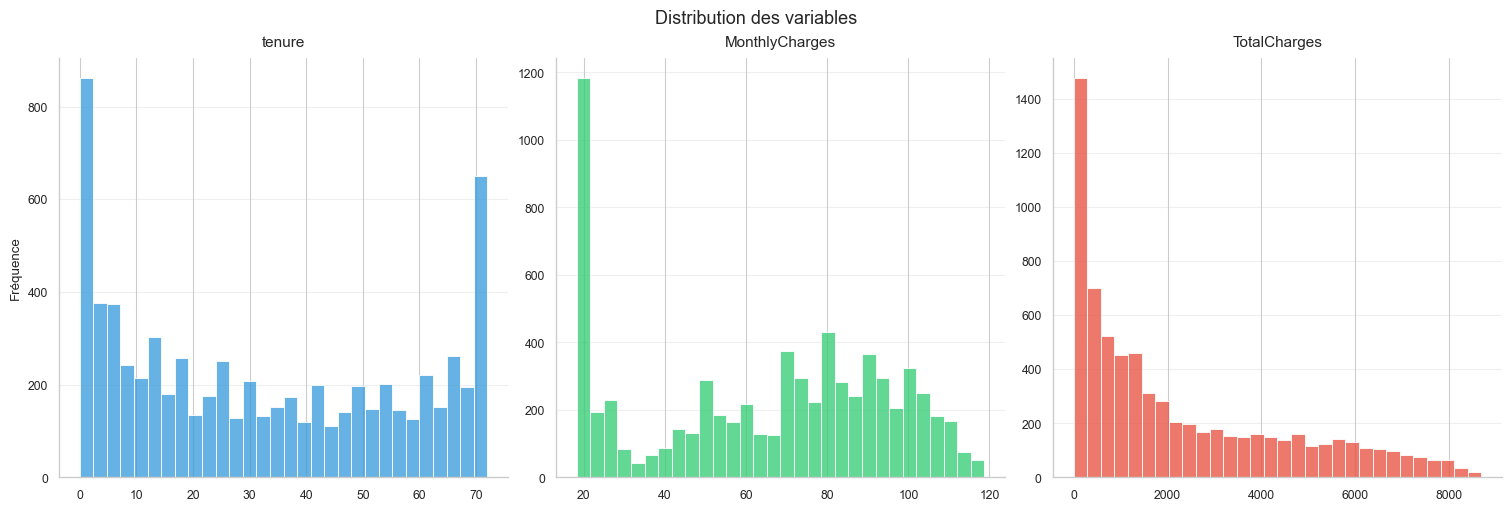

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid",context="paper")
plt.rcParams["font.family"] = "sans-serif"

palette = ["#3498db", "#2ecc71", "#e74c3c"]
num_vars = ["tenure", "MonthlyCharges", "TotalCharges"]
fig, axes = plt.subplots(1, 3,figsize=(15, 5),constrained_layout=True)
for i, col in enumerate(num_vars):
    sns.histplot(data=base,x=col,bins=30,ax=axes[i],color=palette[i],edgecolor="white",linewidth=0.6)
    axes[i].set_title(col, fontsize=11, pad=8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Fréquence" if i == 0 else "")
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)
    axes[i].grid(axis="y", alpha=0.3)
fig.suptitle("Distribution des variables",fontsize=13)
plt.show()


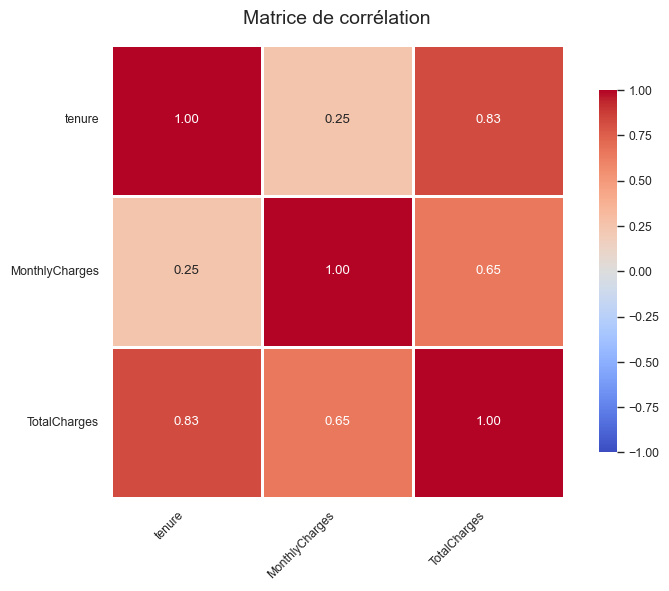

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Calcul de la matrice de corrélation
corr_matrix = base[num_vars].corr()
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
sns.heatmap(corr_matrix,annot=True,fmt='.2f',cmap="coolwarm",center=0,square=True,linewidths=1,linecolor='white',cbar_kws={'shrink': 0.8},ax=ax,vmin=-1,vmax=1)
ax.set_title("Matrice de corrélation", fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### Analyse sur les variables qualitatives

In [55]:
base.columns

Index(['Unnamed: 0', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
      

/var/folders/tn/jbhycnfx3sgb88gbwr675fl80000gn/T/ipykernel_48659/3853498021.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


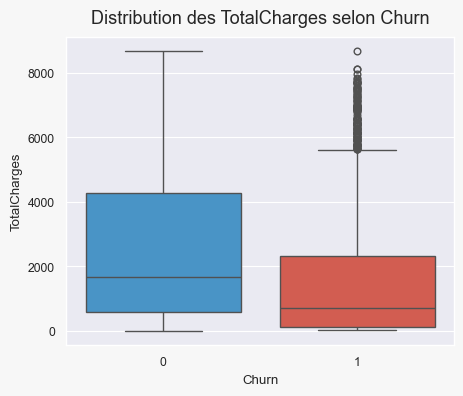

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid", context="paper")
plt.rcParams["figure.facecolor"] = "#f7f7f7"
palette = ["#3498db", "#e74c3c"]  # bleu = non churn, rouge = churn

plt.figure(figsize=(5, 4))
sns.boxplot(
    x="Churn",
    y="TotalCharges",
    data=df,
    palette=palette
)

plt.title("Distribution des TotalCharges selon Churn", fontsize=13, pad=10)
plt.xlabel("Churn")
plt.ylabel("TotalCharges")
plt.show()


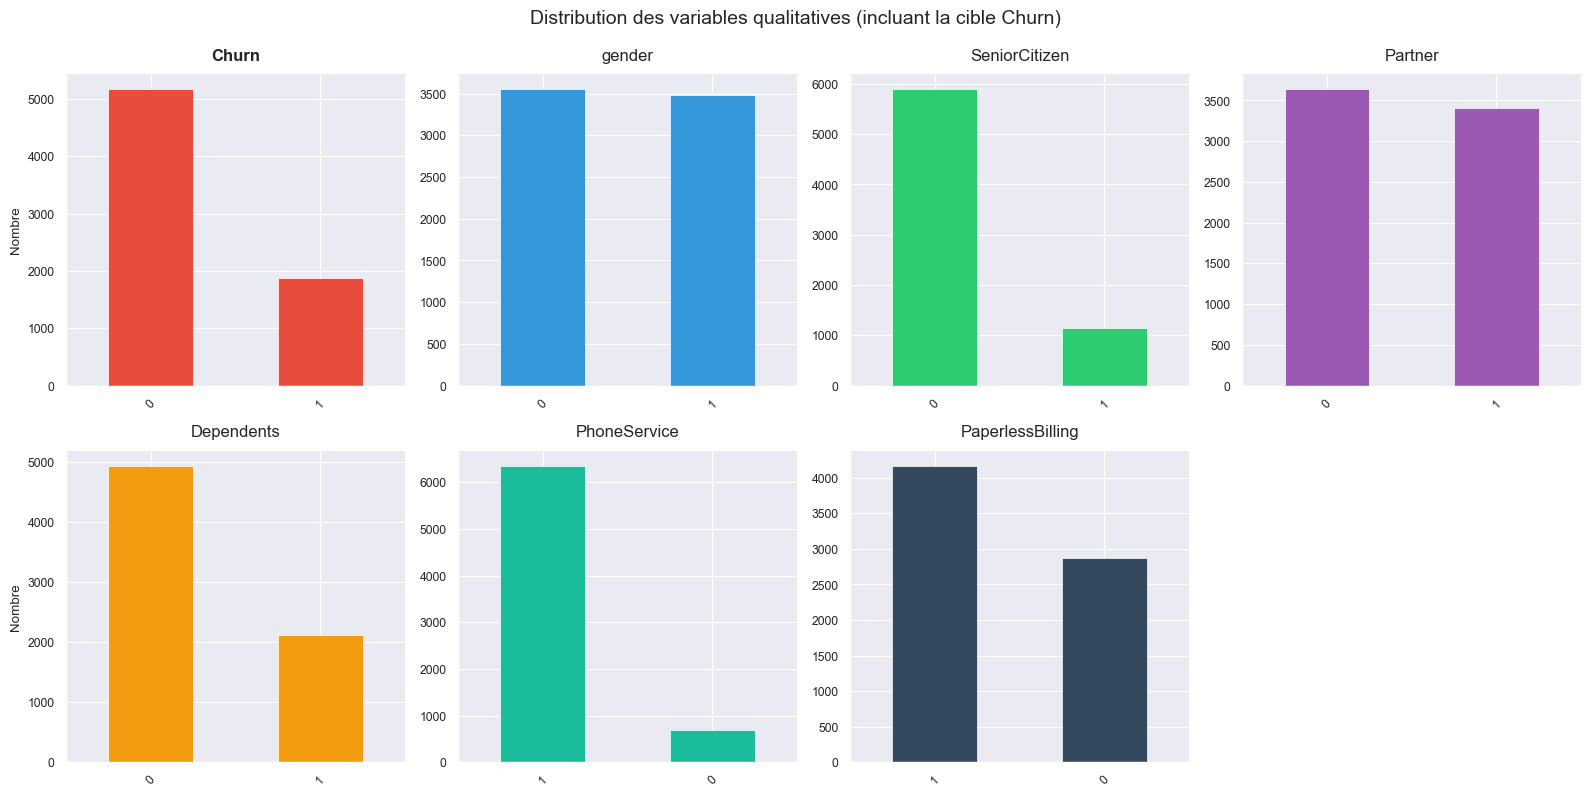

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# ===============================
# Sélection des variables qualitatives intéressantes
# ===============================
cat_vars = ['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

# ======================================
# Graphiques en barres pour variables qualitatives
# ======================================
fig, axes = plt.subplots(2, 4, figsize=(16, 8), facecolor='white')
axes = axes.flatten()

palette = ["#e74c3c", "#3498db", "#2ecc71", "#9b59b6", "#f39c12", "#1abc9c", "#34495e"]

for i, col in enumerate(cat_vars):
    # Comptage des valeurs
    counts = df[col].value_counts()
    
    # Graphique en barres
    counts.plot(
        kind='bar',
        ax=axes[i],
        color=palette[i],
        edgecolor='white',
        linewidth=0.5
    )
    
    axes[i].set_title(col, fontsize=12, pad=10, fontweight='bold' if col == 'Churn' else 'normal')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Nombre' if i % 4 == 0 else '')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].tick_params(axis='x', rotation=45)

# Masquer le dernier subplot vide
axes[-1].axis('off')

fig.suptitle("Distribution des variables qualitatives (incluant la cible Churn)", fontsize=14, y=0.99)
plt.tight_layout()
plt.show()